# Gen App Builder Data Store Status Checker
_Using Google Cloud Discovery Engine APIs for Enterprise Search and Conversational AI_


<table align="left">

  <td>
    <a href="https://colab.research.google.com/github/GoogleCloudPlatform/generative-ai/blob/main/gen-app-builder/data-store-status-checker/data_store_checker.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Colab logo"> Run in Colab
    </a>
  </td>
  <td>
    <a href="https://github.com/GoogleCloudPlatform/generative-ai/blob/main/gen-app-builder/data-store-status-checker/data_store_checker.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo">
      View on GitHub
    </a>
  </td>
  <td>
    <a href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?download_url=https://raw.githubusercontent.com/GoogleCloudPlatform/generative-ai/main/gen-app-builder/data-store-status-checker/data_store_checker.ipynb">
      <img src="https://lh3.googleusercontent.com/UiNooY4LUgW_oTvpsNhPpQzsstV5W8F7rYgxgGBD85cWJoLmrOzhVs_ksK_vgx40SHs7jCqkTkCk=e14-rj-sc0xffffff-h130-w32" alt="Vertex AI logo">
      Open in Vertex AI Workbench
    </a>
  </td>
</table>
<br><br><br>

## What is a Data Store?
A [Data Store](https://cloud.google.com/generative-ai-app-builder/docs/create-datastore-ingest) in [Generative AI App Builder](https://cloud.google.com/generative-ai-app-builder) is a collection of websites or documents, both structured and unstructured, that can be indexed for search and retrieval actions.

Data Stores are the fundamental building block behind [Enterprise Search](https://cloud.google.com/enterprise-search) and [Generative AI Agents](https://cloud.google.com/generative-ai-app-builder/docs/agent-usage).

## Data Store Indexing Time
With each website or set of documents added, the Data Store needs to index the site and/or docuemnts in order for them to be searchable. This can take up to 4 hours for new data store web content to be indexed.

Using the attached example notebook, you can query your Data Store ID to see if indexing is complete.
Once complete, you can additionally use the notebook to search your Data Store for specific pages or documents.

## Limitations
This notebook can only be used to check documents in a `Chat` type Application.  
This will not work for `Search` or `Recommendations` type Applications.

## Objective

Simple notebook that uses the Cloud DiscoveryEngine API to check a Data Store for indexed docs.

---

This notebook utilizes the [google-cloud-discoveryengine](https://cloud.google.com/python/docs/reference/discoveryengine/0.9.1) Python library.  
This notebook allows the user to perform the following tasks:

- ✅ Check Indexing Status of given Data Store ID.
- ✅ List all documents in a given Data Store ID.
- ✅ List all indexed URLs for a given Data Store ID
- ✅ Search all indexed URLs for a specific URL within a given Data Store ID.

---

**References:**

- [Google Cloud DiscoveryEngine API](https://cloud.google.com/python/docs/reference/discoveryengine/latest)

---


* Author: Patrick Marlow
* Created: 07/17/2023

---

# Install PreReqs and Authentication

In [10]:
import sys

if "google.colab" in sys.modules:
    !pip install google-cloud-discoveryengine --quiet

    from google.auth import default
    from google.colab import auth

    auth.authenticate_user()
    creds, _ = default()
else:
    # Otherwise, attempt to discover local credentials as described on https://cloud.google.com/docs/authentication/application-default-credentials
    pass

# Helper Methods
Run the below cell to setup the helper methods for this notebook.

In [4]:
import time
from typing import List, Optional

from google.cloud import discoveryengine_v1beta


def _call_list_documents(
    project_id: str, location: str, datastore_id: str, page_token: str = None
) -> discoveryengine_v1beta.ListDocumentsRequest:
    """Build the List Docs Request payload."""
    request = discoveryengine_v1beta.ListDocumentsRequest(
        parent=f"projects/{project_id}/locations/{location}/collections/default_collection/dataStores/{datastore_id}/branches/0",
        page_size=1000,
    )

    if page_token:
        request.page_token = page_token

    client = discoveryengine_v1beta.DocumentServiceClient()
    res = client.list_documents(request=request)

    return res


def list_documents(
    project_id: str, location: str, datastore_id: str, rate_limit: int = 1
) -> List[discoveryengine_v1beta.Document]:
    """Gets a list of docs in a datastore."""

    res = _call_list_documents(project_id, location, datastore_id)

    # setup the list with the first batch of docs
    docs = res.documents

    while res.next_page_token:
        # implement a rate_limit to prevent quota exhaustion
        time.sleep(rate_limit)

        res = _call_list_documents(
            project_id, location, datastore_id, res.next_page_token
        )
        docs.extend(res.documents)

    return docs


def list_indexed_urls(
    project_id: str,
    location: str,
    datastore_id: str,
    docs: Optional[List[discoveryengine_v1beta.Document]] = None,
) -> List[str]:
    """Get the list of docs in datastore, then parse to only urls."""
    if not docs:
        docs = list_documents(project_id, location, datastore_id)
    urls = [doc.content.uri for doc in docs]

    return urls


def search_url(urls: List[str], url: str) -> None:
    """Searches a url in a list of urls."""
    for item in urls:
        if url in item:
            print(item)


def search_doc_id(
    doc_id: str,
    docs: Optional[List[discoveryengine_v1beta.Document]] = None,
    project_id: str = None,
    location: str = None,
    datastore_id: str = None,
) -> None:
    """Searches a doc_id in a list of docs."""
    if not docs:
        docs = list_documents(project_id, location, datastore_id)

    doc_found = False
    for doc in docs:
        if doc.parent_document_id == doc_id:
            doc_found = True
            print(doc)

    if not doc_found:
        print(f"Document not found for provided Doc ID: `{doc_id}`")


PENDING_MESSAGE = """
No docs found.\n\nIt\'s likely one of two issues: \n  [1] Your data store is not finished indexing. \n  [2] Your data store failed indexing.\n
If you just added your data store, it can take up to 4 hours before it will become available.
"""

# User Inputs
You can find your `datastore_id` by going following these steps:
1. Click on Gen App Builder   
2. Select your App / Engine

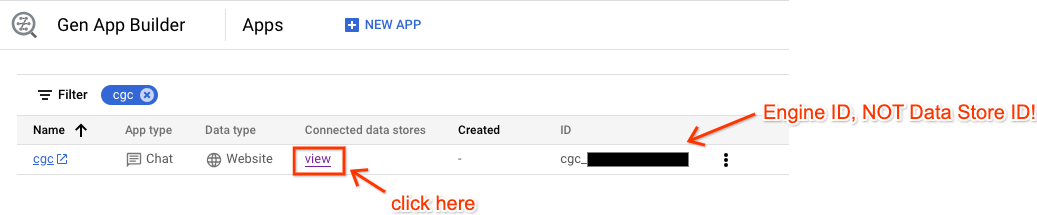

3. Select your Available Data Store 

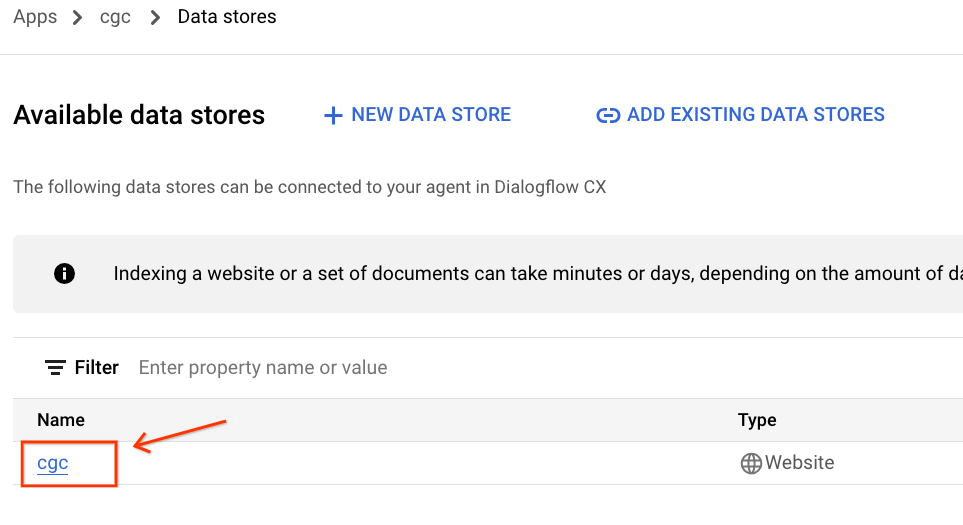


4. Find your Data Store ID

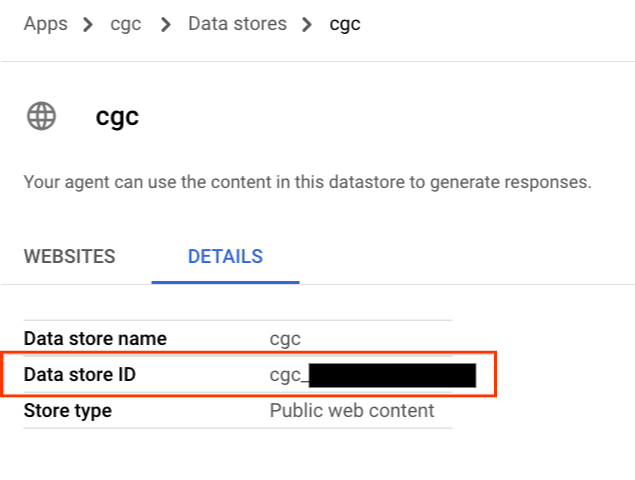

In [8]:
project_id = "YOUR-PROJECT-ID"
location = "global"
datastore_id = "YOUR_DATA_STORE_ID"

# Check Data Store Index Status
Using the `list_documents` method, we can do a check to see if the data store has finished indexing.

In [9]:
docs = list_documents(project_id, location, datastore_id)

if len(docs) == 0:
    print(PENDING_MESSAGE)
else:
    SUCCESS_MESSAGE = f"""
  Success! 🎉\n
  Your indexing is complete.\n
  Your index contains {len(docs)} documents.
  """
    print(SUCCESS_MESSAGE)


No docs found.

It's likely one of two issues: 
  [1] Your data store is not finished indexing. 
  [2] Your data store failed indexing.

If you just added your data store, it can take up to 4 hours before it will become available.



# List Documents
List all the documents for a given Data Store ID

In [6]:
docs = list_documents(project_id, location, datastore_id)
docs[0]

struct_data {
}
name: "projects/772105163160/locations/global/collections/default_collection/dataStores/cgc_1690226759325/branches/0/documents/000a98558b6fe9aef7992c9023fb7fdb"
id: "000a98558b6fe9aef7992c9023fb7fdb"
schema_id: "default_schema"
content {
  uri: "https://cloud.google.com/docs/security/data-loss-prevention/revoking-user-access?hl=es-419"
  mime_type: "text/html"
}
parent_document_id: "000a98558b6fe9aef7992c9023fb7fdb"

# Search Data Store by Doc ID
Search through all Docs in a given Data Store and find a specific Doc ID.

In [8]:
document_id = "000a98558b6fe9aef7992c9023fb7fdb"

search_doc_id(document_id, docs)

struct_data {
}
name: "projects/772105163160/locations/global/collections/default_collection/dataStores/cgc_1690226759325/branches/0/documents/000a98558b6fe9aef7992c9023fb7fdb"
id: "000a98558b6fe9aef7992c9023fb7fdb"
schema_id: "default_schema"
content {
  uri: "https://cloud.google.com/docs/security/data-loss-prevention/revoking-user-access?hl=es-419"
  mime_type: "text/html"
}
parent_document_id: "000a98558b6fe9aef7992c9023fb7fdb"



# List Indexed URLs

In [9]:
urls = list_indexed_urls(project_id, location, datastore_id, docs)
urls[0]

'https://cloud.google.com/docs/security/data-loss-prevention/revoking-user-access?hl=es-419'

# Search Indexed URLs

In [22]:
search_url(urls, "https://cloud.google.com/docs/terraform/samples")

https://cloud.google.com/docs/terraform/samples?hl=ko
https://cloud.google.com/docs/terraform/samples?hl=fr
https://cloud.google.com/docs/terraform/samples?hl=pt-br
https://cloud.google.com/docs/terraform/samples?hl=de
https://cloud.google.com/docs/terraform/samples?hl=zh-cn
https://cloud.google.com/docs/terraform/samples?hl=ja
https://cloud.google.com/docs/terraform/samples
https://cloud.google.com/docs/terraform/samples?hl=es-419
https://cloud.google.com/docs/terraform/samples?hl=it


In [23]:
search_url(urls, "terraform")

https://cloud.google.com/docs/terraform/getting-support?hl=de
https://cloud.google.com/docs/terraform/basic-commands?hl=ko
https://cloud.google.com/docs/terraform/policy-validation/create-cai-constraints?hl=es-419
https://cloud.google.com/docs/terraform/samples?hl=ko
https://cloud.google.com/docs/terraform/get-started-with-terraform?hl=es-419
https://cloud.google.com/docs/terraform/policy-validation/create-terraform-constraints?hl=de
https://cloud.google.com/docs/terraform/resource-management/managing-infrastructure-as-code?hl=ko
https://cloud.google.com/docs/terraform/deploy-foundation-using-terraform-from-console?hl=pt-br
https://cloud.google.com/docs/terraform/resource-management/store-state?hl=de
https://cloud.google.com/docs/terraform/policy-validation/migrate-from-terraform-validator?hl=it
https://cloud.google.com/docs/terraform/get-started-with-terraform?hl=he
https://cloud.google.com/docs/terraform/policy-validation/create-terraform-constraints?hl=he
https://cloud.google.com/do